# 练习任务1：运用ImageDataGenerator对数据进行增广

In [113]:
# for tf2.0
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Input,MaxPooling2D,Dropout,BatchNormalization,Conv2DTranspose,UpSampling2D,ZeroPadding2D,concatenate
from tensorflow.keras.optimizers import RMSprop,Adam
import matplotlib.pyplot as plt
import glob
import time
from sklearn.model_selection import train_test_split
from skimage import io
from historycal import LossHistory
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from PIL import Image

* step2 加载数据并完成预处理

In [114]:
image_path = './sea_ice\\image\\'
mask_path = './sea_ice\\label\\'
result_path = './prediction\\'
target_size = (256,256)

In [116]:
# first of all check the image format,confirm the max value (uint8 0-255)
def Load_Color_Data(image_path, mask_path):
    image_name_arr = glob.glob(os.path.join(image_path,"*.jpg"))
    image_arr = []
    mask_arr = []
    
    for index,item in enumerate(image_name_arr):
        img = io.imread(item)
        # img=np.resize(img,(256,256))
        # img = np.reshape(img,img.shape + (1,))
        # print(item,item.replace(image_path,mask_path))
        mask = io.imread(item.replace(image_path,mask_path))
        # mask=np.resize(mask,(256,256))
        # mask = np.reshape(mask,img.shape  + (1,))
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        image_arr.append(img)
        mask_arr.append(mask)

    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr, mask_arr

def plot_func(data,label):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,0])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,0]),cmap="gray")
    plt.show()

In [117]:
images, labels = Load_Color_Data(image_path, mask_path)
# images = np.reshape(images,images.shape + (1,))
labels = np.reshape(labels, labels.shape + (1,))
threshold = 500
xtrain, xtest, ytrain, ytest = train_test_split(images[:threshold], labels[:threshold], test_size=0.3)
xval=images[threshold:]
yval=labels[threshold:]
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape,xval.shape,yval.shape)

(350, 256, 256, 3) (150, 256, 256, 3) (350, 256, 256, 1) (150, 256, 256, 1) (200, 256, 256, 3) (200, 256, 256, 1)


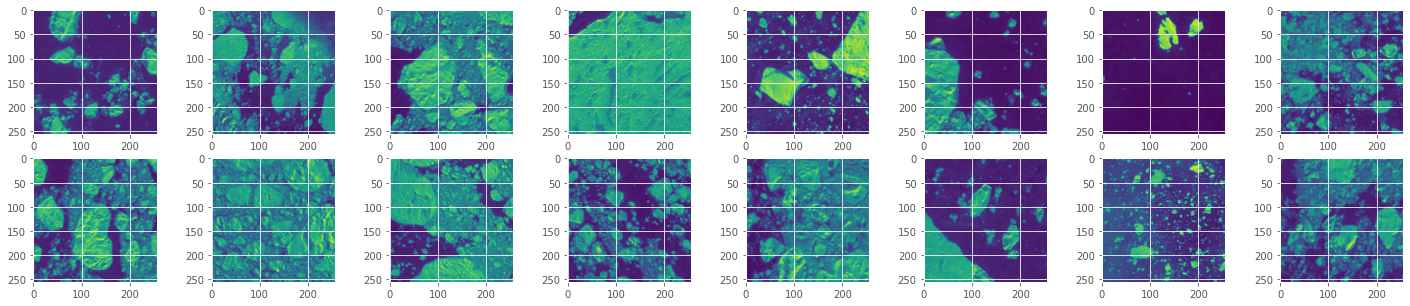

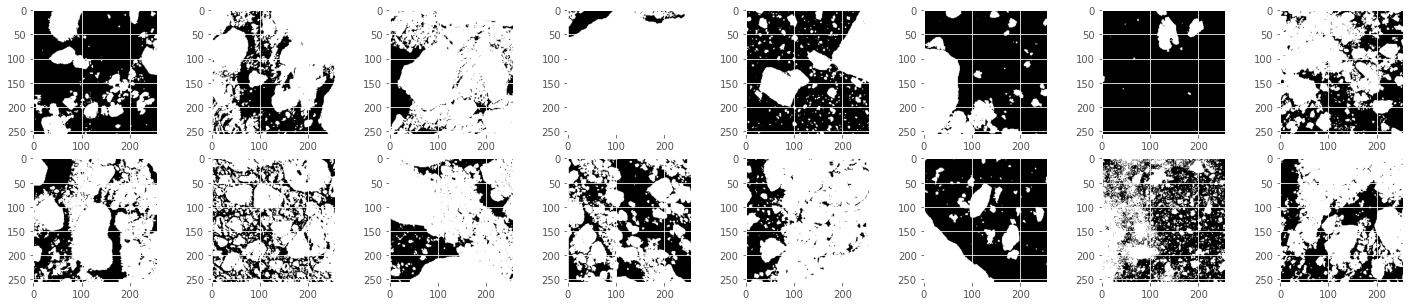

In [118]:
# Check whether the images are consistent with the labels
plot_func(xtrain,ytrain)

* setp3 数据增强

* 方法一：使用flow 进行数据增强

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [76]:
def datagen(xtrain, ytrain, batach_size):
    data_gen_args = dict(
                        featurewise_center=False,
                        samplewise_center=False,
                        featurewise_std_normalization=False,
                        samplewise_std_normalization=False,
                        zca_whitening=False,
                        # zca_epsilon=1e-6,
                        rotation_range=0.2,
                        width_shift_range=0,
                        height_shift_range=0,
                        shear_range=0.1,
                        zoom_range=0.1,
                        channel_shift_range=0.,
                        fill_mode='nearest',
                        cval=0,
                        horizontal_flip=True,
                        vertical_flip=True,
                        rescale=None,
                        preprocessing_function=None,)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    imageiter = image_datagen.flow(xtrain, batch_size=batch_size,seed=seed)
    labeliter = mask_datagen.flow(ytrain, batch_size=batch_size,seed=seed)
    return imageiter, labeliter

* 可视化数据增强的结果

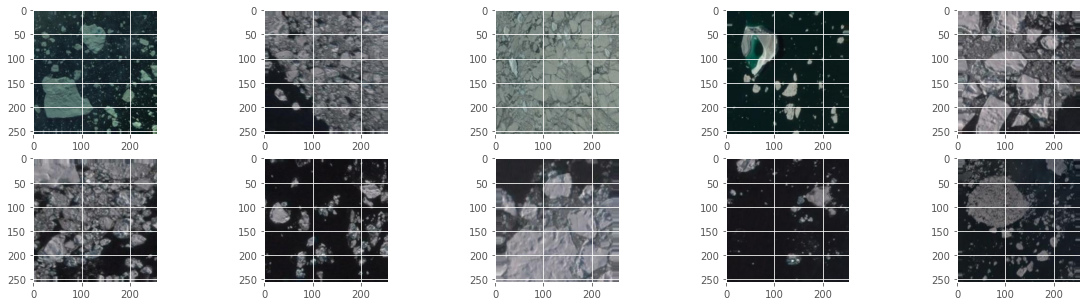

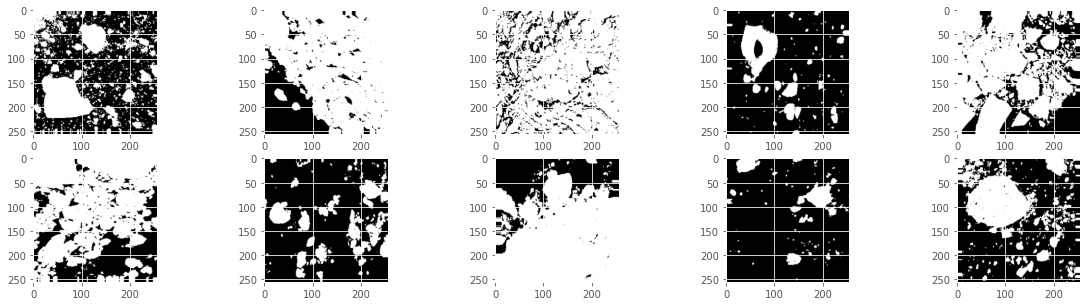

In [119]:
imageiter,labeliter=datagen(xtrain,ytrain,20)
data,label=next(imageiter),next(labeliter)

fig=plt.figure(figsize=(20,5))
for i in range(10):   
    plt.subplot(2,5,i+1)
    plt.imshow((data[i,:,:,:]))
plt.show()
fig=plt.figure(figsize=(20,5))
for i in range(10):   
    plt.subplot(2,5,i+1)
    plt.imshow((label[i,:,:,0]),cmap="gray")
plt.show()

* 另一种数据增强的方法

* 方法二：使用flow_flom_directory 进行数据增强

In [6]:
data_gen_args = dict(
#                      rescale=1/255.0,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
                    rotation_range=0.2,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range = 0.0,
                    channel_shift_range=0.1)
image_datagen = ImageDataGenerator(**data_gen_args)

indir='sea_ice/'
image_generator = image_datagen.flow_from_directory(indir,
    target_size=(256,256),
    class_mode=None,
    # save_to_dir = indir+'augimage',
    save_prefix  = 'image',
    seed=42)

mask_generator = image_datagen.flow_from_directory(indir,
    target_size=(256,256),
    class_mode=None,
    # save_to_dir = indir+'auglabel',
    save_prefix  = 'label',
    seed=42)

Found 1400 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.


In [90]:
for x in image_generator:
    print(x)
    break

[[[[200. 203. 212.]
   [206. 209. 218.]
   [173. 176. 183.]
   ...
   [ 78.  79.  83.]
   [ 50.  54.  57.]
   [ 71.  75.  78.]]

  [[172. 175. 184.]
   [182. 185. 194.]
   [173. 176. 183.]
   ...
   [ 96.  97. 101.]
   [ 59.  63.  66.]
   [ 73.  77.  80.]]

  [[125. 128. 137.]
   [143. 146. 155.]
   [168. 171. 178.]
   ...
   [107. 108. 112.]
   [ 67.  71.  74.]
   [ 78.  82.  85.]]

  ...

  [[ 49.  52.  57.]
   [ 64.  67.  72.]
   [ 44.  47.  52.]
   ...
   [ 51.  50.  55.]
   [ 49.  48.  53.]
   [ 45.  44.  49.]]

  [[ 41.  44.  49.]
   [ 56.  59.  64.]
   [ 35.  38.  43.]
   ...
   [ 58.  57.  62.]
   [ 58.  57.  62.]
   [ 54.  53.  58.]]

  [[ 23.  26.  31.]
   [ 38.  41.  46.]
   [ 20.  23.  28.]
   ...
   [ 53.  52.  57.]
   [ 52.  51.  56.]
   [ 47.  46.  51.]]]


 [[[ 69.  74.  78.]
   [ 69.  74.  78.]
   [ 76.  81.  85.]
   ...
   [ 40.  39.  44.]
   [ 42.  41.  46.]
   [ 44.  43.  48.]]

  [[ 64.  69.  73.]
   [ 67.  72.  76.]
   [ 78.  83.  87.]
   ...
   [ 39.  38.  43.]
 

In [93]:
#  combine generators into one which yields image and masks
train_generator = zip(imageiter, labeliter)

* step4 建立U-Net网络

In [94]:
def unet(input_size,optimizer,loss,metrics):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    # conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,outputs)

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    return model


* step5 设置超参

In [95]:
loss='binary_crossentropy'
optimizer=Adam(lr=0.001)##SGD(),Adamax(),Adadelta()RAdam()
metrics=['accuracy']
input_height=256
input_width=256
nclass=1
nchannel=3
epoch=10
batch_size=40
nickname='unet'
input_size=(input_height,input_width,nchannel)
model=unet(input_size,optimizer,loss,metrics)
# model.summary()

C:\Users\agrs\.conda\envs\keras\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


* step6 训练模型

In [103]:
result = model.fit(train_generator, steps_per_epoch=100, epochs= 30)

Epoch 1/30
100/100 [==============================] - 81s 807ms/step - loss: 0.0868 - accuracy: 0.8909
Epoch 2/30
100/100 [==============================] - 80s 802ms/step - loss: 0.0853 - accuracy: 0.8919
Epoch 3/30
100/100 [==============================] - 80s 799ms/step - loss: 0.0852 - accuracy: 0.8915
Epoch 4/30
100/100 [==============================] - 81s 808ms/step - loss: 0.0846 - accuracy: 0.8920
Epoch 5/30
100/100 [==============================] - 81s 808ms/step - loss: 0.0835 - accuracy: 0.8920
Epoch 6/30
100/100 [==============================] - 81s 810ms/step - loss: 0.0843 - accuracy: 0.8919
Epoch 7/30
100/100 [==============================] - 81s 809ms/step - loss: 0.0811 - accuracy: 0.8927
Epoch 8/30
100/100 [==============================] - 81s 808ms/step - loss: 0.0805 - accuracy: 0.8928
Epoch 9/30
100/100 [==============================] - 81s 806ms/step - loss: 0.0817 - accuracy: 0.8929
Epoch 10/30
100/100 [==============================] - 81s 807ms/step - l

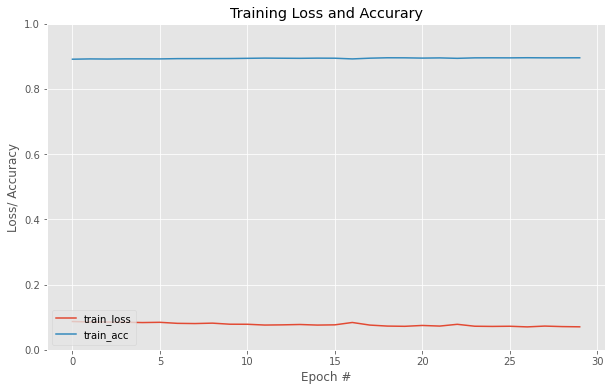

In [108]:
def plot_fig(H):
    N = len(result.history['loss'])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.ylim(0,1)

    plt.title("Training Loss and Accurary")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/ Accuracy")
    plt.legend(loc="lower left")
    plt.show()
plot_fig(result)

5/5 [==============================] - 1s 221ms/step - loss: 0.0846 - accuracy: 0.9702
0.08457206934690475 0.970160961151123


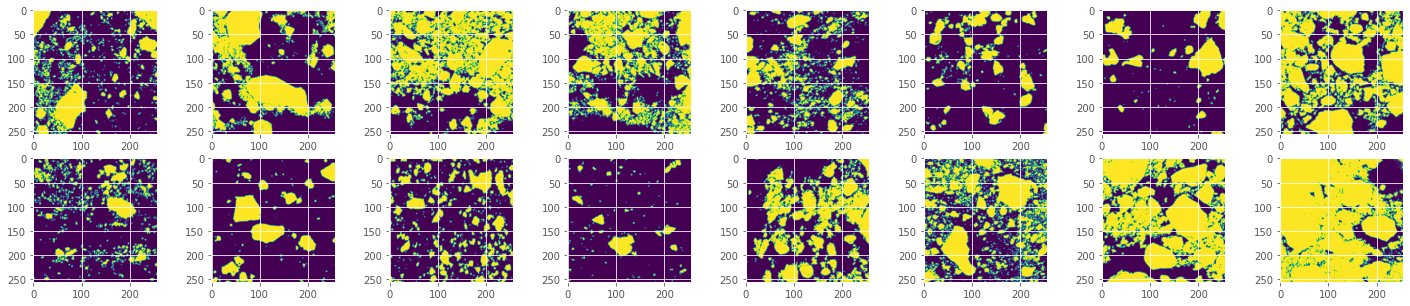

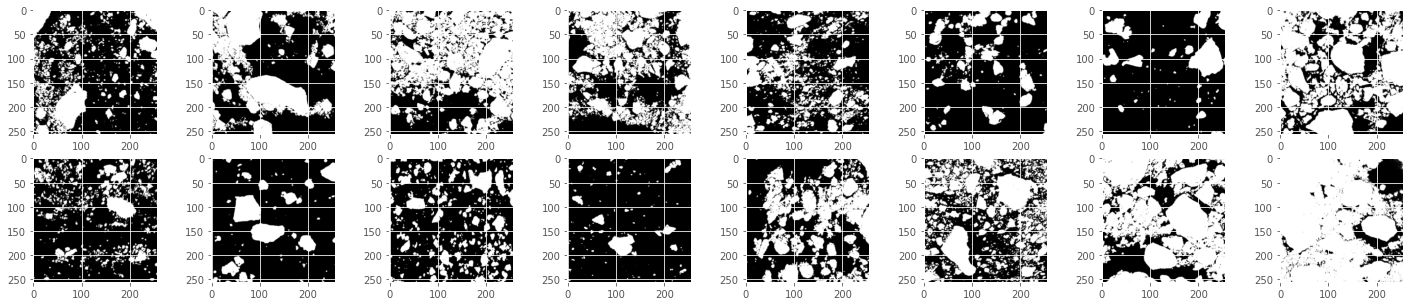

In [111]:
val_loss,val_acc=model.evaluate(x=xval,y=yval, batch_size=40, verbose=1)
print(val_loss,val_acc)
pred=model.predict(xval)
plot_func(pred,pred*255)